<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.1.3-LSTMB16-1mil-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prototype (16 units Balanced Weights)

Running LSTM with balanced weights with only 16 units

With 500k examples, our score was 0.385

# Result

We are seeing a decrease in score again from 500k to 1 million examples. The score for this run is 0.3532278758036526

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight




import random
import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)



logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 16 # total LSTM units
MODEL_NAME = f"LSTMB{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units - Balanced Weights"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 2

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-1m-preprocessed.csv"


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100



In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=109547
Number of Documents=746766
Train review vectors shape: (746766, 100)  Test review vectors shape: (248922, 100)


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts)+1

# building our network
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          32864400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 32,884,773
Trainable params: 32,884,773
Non-trainable params: 0
_________________________________________________________________
None


In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                            #   factor=0.4,
                            #   patience=PATIENCE, 
                            #   min_lr=0.00001,
                            #  mode='auto',
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.42284845 3.02709736 2.2103805  1.20013018 0.37296994]
Number of training examples: 746766
Train on 597412 samples, validate on 149354 samples
Epoch 1/50
597412/597412 [==============================] - 1466s 2ms/sample - loss: 0.8217 - categorical_accuracy: 0.6808 - val_loss: 0.7688 - val_categorical_accuracy: 0.6986
Epoch 2/50
597412/597412 [==============================] - 1472s 2ms/sample - loss: 0.7279 - categorical_accuracy: 0.7138 - val_loss: 0.7596 - val_categorical_accuracy: 0.7021
Epoch 3/50
597412/597412 [==============================] - 1498s 3ms/sample - loss: 0.6813 - categorical_accuracy: 0.7332 - val_loss: 0.7693 - val_categorical_accuracy: 0.6996
Epoch 4/50
597412/597412 [==============================] - 1486s 2ms/sample - loss: 0.6407 - categorical_accuracy: 0.7513 - val_loss: 0.7910 - val_categorical_accuracy: 0.6979
Epoch 00004: early stopping


Number of test: 248922
Running model.evaluate...
248922/248922 [==============================] - 51s 205us/sample - loss: 0.7866 - categorical_accuracy: 0.6987
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(248922, 5)
Getting classification report...
Accuracy: 69.87%


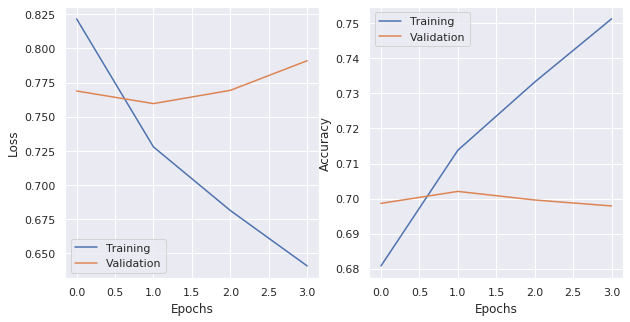


Confusion Matrix
[[ 27936   2855   2173    525   1674]
 [  7192   3019   3760   1020   1507]
 [  3435   2156   7710   4474   4584]
 [   993    579   3998  12597  23148]
 [  1280    313   1770   7552 122672]]

Classification Report
              precision    recall  f1-score   support

           1       0.68      0.79      0.74     35163
           2       0.34      0.18      0.24     16498
           3       0.40      0.34      0.37     22359
           4       0.48      0.30      0.37     41315
           5       0.80      0.92      0.85    133587

    accuracy                           0.70    248922
   macro avg       0.54      0.51      0.51    248922
weighted avg       0.66      0.70      0.67    248922



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

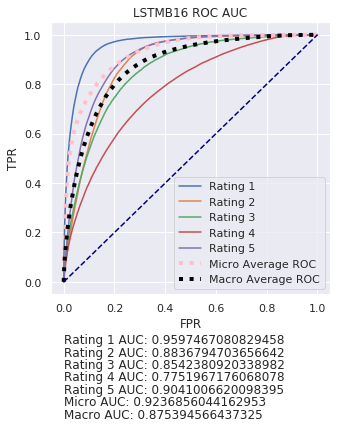

In [8]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [9]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.3532278758036526


**Save off various files**

In [10]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB16-1x16-random_embedding-sampling_none-995688-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-random_embedding-sampling_none-995688-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-random_embedding-sampling_none-995688-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-random_embedding-sampling_none-995688-100-star_rating-weights.h5
Saving history file: drive/My Drive/Springboard/capstone/models/LSTMB16-1x16-random_embedding-sampling_none-995688-100-star_rating-history.h5


TypeError: ignored

In [0]:
# manully save these since there was a bug with saving network file
import pickle
pickle.dump(mw.tokenizer, open(mw.tokenizer_file, 'wb'))


In [12]:
# manually save report file
report = mw.get_report()
report.save(mw.report_file, append=True)


Loading to append to: drive/My Drive/Springboard/capstone/reports/2020-02-dl_prototype-report.csv
{'model_name': 'LSTMB16', 'architecture': '1x16', 'description': '1 Layer 16 LSTM Units and 20% 1D Spatial Dropout - Balanced Weights', 'classification_report': '{"1": {"precision": 0.6841022627093741, "recall": 0.794471461479396, "f1-score": 0.7351675679943157, "support": 35163}, "2": {"precision": 0.338377045505492, "recall": 0.18299187780337012, "f1-score": 0.23752950432730138, "support": 16498}, "3": {"precision": 0.3971974653546958, "recall": 0.3448275862068966, "f1-score": 0.3691644721091693, "support": 22359}, "4": {"precision": 0.4813894833384286, "recall": 0.30490136754205494, "f1-score": 0.3733384704295897, "support": 41315}, "5": {"precision": 0.7987238337077188, "recall": 0.9182929476670634, "f1-score": 0.8543451311409189, "support": 133587}, "accuracy": 0.6987490057126329, "macro avg": {"precision": 0.5399580181231419, "recall": 0.5090970481397562, "f1-score": 0.51390902920025

,accuracy,architecture,batch_size,class_weight,classification_report,confusion_matrix,description,embedding,epochs,evaluate_time_min,feature_set_name,file,loss,max_sequence_length,model_file,model_json_file,model_name,predict_time_min,roc_auc,sampling_type,status,status_date,test_examples,test_features,tokenizer_file,train_examples,train_features,train_time_min,weights_file
0,0.676502,1x64,128.0,"[1.4363387189844201, 3.078518976578805, 2.1884...","{""1"": {""precision"": 0.664646198445118, ""recall...","[[5044, 789, 546, 139, 463], [1320, 655, 676, ...",1 Layer 64 LSTM Units with no Dropout - Balanc...,300.0,4.0,0.16,random_embedding,drive/My Drive/Springboard/capstone/data/amazo...,0.877478,100.0,drive/My Drive/Springboard/capstone/models/LST...,drive/My Drive/Springboard/capstone/models/LST...,LSTMB_nodropout,0.12,"{""auc_1"": 0.9479297646580732, ""auc_2"": 0.86543...",none,success,2020-02-05 01:44:49,49784.0,100.0,drive/My Drive/Springboard/capstone/models/dl-...,149350.0,100.0,11.22,drive/My Drive/Springboard/capstone/models/LST...
1,0.680178,1x64,128.0,"[1.4363387189844201, 3.078518976578805, 2.1884...","{""1"": {""precision"": 0.6407869934024505, ""recal...","[[5439, 603, 407, 102, 430], [1477, 563, 626, ...",1 Layer 64 LSTM Units with no Dropout - Balanc...,300.0,4.0,0.16,random_embedding,drive/My Drive/Springboard/capstone/data/amazo...,0.817394,100.0,drive/My Drive/Springboard/capstone/models/LST...,drive/My Drive/Springboard/capstone/models/LST...,LSTMB_nodropout_restore,0.12,"{""auc_1"": 0.9524739842501337, ""auc_2"": 0.86877...",none,success,2020-02-05 02:00:57,49784.0,100.0,drive/My Drive/Springboard/capstone/models/dl-...,149350.0,100.0,10.99,drive/My Drive/Springboard/capstone/models/LST...
2,0.700486,1x64,128.0,"[1.4190206082718126, 3.030958904109589, 2.2082...","{""1"": {""precision"": 0.7025432616675407, ""recal...","[[5359, 544, 513, 127, 403], [1289, 612, 872, ...",1 Layer 64 LSTM Units No Dropout - Balanced We...,300.0,4.0,0.16,random_embedding,drive/My Drive/Springboard/capstone/data/amazo...,0.761258,100.0,drive/My Drive/Springboard/capstone/models/LST...,drive/My Drive/Springboard/capstone/models/LST...,LSTMB_nodropout,0.13,"{""auc_1"": 0.9613279508344518, ""auc_2"": 0.89276...",none,success,2020-02-05 03:11:06,49784.0,100.0,drive/My Drive/Springboard/capstone/models/dl-...,448051.0,100.0,54.90,drive/My Drive/Springboard/capstone/models/LST...
3,0.694460,1x64,128.0,"[1.4190206082718126, 3.030958904109589, 2.2082...","{""1"": {""precision"": 0.6945244956772334, ""recal...","[[5302, 752, 401, 145, 346], [1262, 875, 644, ...","1 Layer 64 LSTM Units No Dropout, restore best...",300.0,9.0,0.14,random_embedding,drive/My Drive/Springboard/capstone/data/amazo...,0.785522,100.0,drive/My Drive/Springboard/capstone/models/LST...,drive/My Drive/Springboard/capstone/models/LST...,LSTMB_nodropout_restore_patience8,0.11,"{""auc_1"": 0.9596540140170374, ""auc_2"": 0.88933...",none,success,2020-02-05 05:30:45,49784.0,100.0,drive/My Drive/Springboard/capstone/models/dl-...,448051.0,100.0,119.93,drive/My Drive/Springboard/capstone/models/LST...
4,0.711416,1x64,128.0,"[1.4228484463085092, 3.0270973626206583, 2.210...","{""1"": {""precision"": 0.6798441617967228, ""recal...","[[11866, 729, 820, 137, 644], [3154, 967, 1544...","1 Layer 64 LSTM Units, no Dropout - Balanced W...",300.0,10.0,0.28,random_embedding,drive/My Drive/Springboard/capstone/data/amazo...,0.735806,100.0,drive/My Drive/Springboard/capstone/models/LST...,drive/My Drive/Springboard/capstone/models/LST...,LSTMB_nodropout,0.21,"{""auc_1"": 0.9650483217403132, ""auc_2"": 0.89383...",none,success,2020-02-05 11:21:35,99569.0,100.0,drive/My Drive/Springboard/capstone/models/dl-...,896119.0,100.0,375.71,drive/My Drive/Springboard/capstone/models/LST...
5,0.677226,1x32,128.0,"[1.4363387189844201, 3.078518976578805, 2.1884...","{""1"": {""precision"": 0.6662372794022929, ""recal...","[[5172, 659, 460, 107, 583], [1340, 606, 661, ...",1 Layer 32 LSTM Units and 20% 1D

In [13]:
print(datetime.now())

2020-02-07 00:18:48.685153
